In [1]:
# Suppress Warning messages
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [4]:
PROBLEM_NAME = 'FourPeaks'

# PARAM_NAME = 'Max Restarts'
# PARAM_KEY = 'max_restarts'
# ALGORITHM_NAME = 'RHC'

# PARAM_NAME = 'Temperature'
# PARAM_KEY = 'start_temperature'
# ALGORITHM_NAME = 'SA'

PARAM_NAME = 'Mutation Rate'
PARAM_KEY = 'mutation_rate'
ALGORITHM_NAME = 'GA'

# PARAM_NAME = 'Keep Percent'
# PARAM_KEY = 'keep_percent'
# ALGORITHM_NAME = 'MIMIC'

In [5]:
PROBLEM_SIZE = 500
T_PCT = '0.1'

In [7]:
out_dir = f'metrics/learning_curves_t_pct_{T_PCT}_n_{PROBLEM_SIZE}'
os.makedirs(out_dir, exist_ok=True)

In [8]:
# all_df = pd.read_csv(f'metrics/{PROBLEM_NAME}_500_{ALGORITHM_NAME}_small/learning_curve.csv')
all_df = pd.read_csv(f'metrics/{PROBLEM_NAME}_{PROBLEM_SIZE}_{ALGORITHM_NAME}/learning_curve.csv')

In [9]:
if ALGORITHM_NAME == 'RHC':
    for run_num in tqdm(all_df['run_number'].unique()):
        add_time = 0
        s_all_df = all_df[all_df['run_number'] == run_num]
        for restart in sorted(s_all_df['current_restart'].unique()):
            mask = np.logical_and(all_df['run_number'] == run_num, all_df['current_restart'] == restart)
            all_df.loc[mask, 'Time'] = all_df.loc[mask, 'Time'] + add_time
            add_time = all_df[mask]['Time'].max()

In [10]:
# for run_num in tqdm(all_df['run_number'].unique()):
#     best_fitness = None
#     s_all_df = all_df[all_df['run_number'] == run_num]
#     for i, row in s_all_df.iterrows():
#         if best_fitness is None or row['Fitness'] > best_fitness:
#             best_fitness = row['Fitness']
#         all_df.loc[i, 'Fitness'] = best_fitness

In [11]:
max_time = all_df['Time'].max()
param_values = all_df[PARAM_KEY].unique()
metric_dict = {}
print(len(param_values))
for param_value in param_values:
    df = all_df[all_df[PARAM_KEY] == param_value]
    run_num = df['run_number'].unique()[0]
    run_df = df[df['run_number'] == run_num]
    print(len(run_df))
    for i, row in tqdm(run_df.iterrows()):
        s_df = all_df[all_df['Iteration'] == row['Iteration']]
        run_df.loc[i, 'fitness_mean'] = s_df['Fitness'].mean()
        run_df.loc[i, 'fitness_std'] = s_df['Fitness'].std()
    run_df = run_df.sort_values('Time')
    run_df = run_df.iloc[1:]
    X = np.array(run_df['Time'])
    y = np.array(run_df['fitness_mean'])
    y_error = np.array(run_df['fitness_std'])
    metric_dict[param_value] = (X, y, y_error)

4
910


910it [00:00, 1129.59it/s]


701


701it [00:00, 1402.06it/s]


1001


1001it [00:00, 1362.45it/s]


1001


1001it [00:00, 1376.10it/s]


4


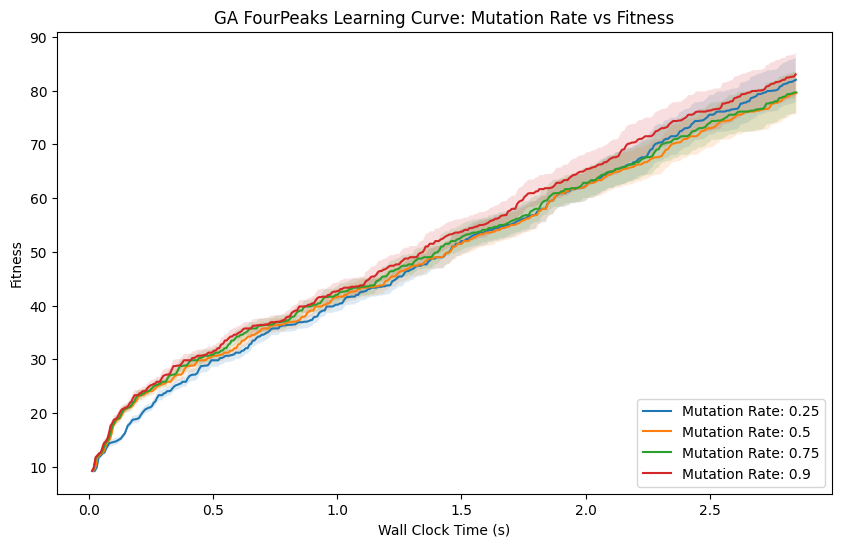

In [12]:
x_lim = 3
EXTEND = False
plt.figure(figsize=(10, 6))
max_time = all_df['Time'].max()
param_values = all_df[PARAM_KEY].unique()
print(len(param_values))
for param_value, (X, y, y_error) in metric_dict.items():
    if EXTEND:
        y = np.append(y, y[-1])
        X = np.append(X, max_time)
        y_error = np.append(y_error, y_error[-1])
    y_error = y_error / 5
    X = X[X <= (0.95 * x_lim)]
    y = y[:len(X)]
    y_error = y_error[:len(X)]
    plt.plot(X, y, label=f"{PARAM_NAME}: {param_value}")
    plt.fill_between(X, y-y_error, y+y_error, alpha=0.15)
# set xlabel to Wall Clock Time (s) 
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Fitness')
# set legend position to bottom right
plt.legend(loc='lower right')
plt.title(f'{ALGORITHM_NAME} {PROBLEM_NAME} Learning Curve: {PARAM_NAME} vs Fitness'.format(PARAM_NAME))

save_path = os.path.join(out_dir, f"{ALGORITHM_NAME}_{PROBLEM_NAME}_{PARAM_NAME}_vs_Fitness.png") 
plt.savefig(save_path)

In [ ]:
colors = ['b', 'orange', 'g', 'r', 'purple']
fig, ax = plt.subplots(figsize=(8, 6))

x_pos = np.arange(len(param_values))
means = []
stds = []
mean_times = []

for param_value in param_values:
    df = all_df[all_df[PARAM_KEY] == param_value]
    best_fitnesses = []
    times = []
    for run_i in df['run_number'].unique():
        run_df = df[df['run_number'] == run_i]
        run_df = run_df[run_df['Time'] < x_lim]
        best_fitnesses.append(run_df['Fitness'].max())
        max_df = run_df[run_df['Fitness'] == run_df['Fitness'].max()]
        t = max_df['Time'].values[0]
        if ALGORITHM_NAME == 'RHC':
            t *= max_df['current_restart'].max()
        times.append(t)
    f = np.mean(best_fitnesses)
    means.append(f)
    s = f"Best Fitness = {round(f)}\n({round(np.mean(times), 2)} sec)"
    mean_times.append(s)
    stds.append(np.std(best_fitnesses))
    
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', color=colors, capsize=10)
ax.set_ylabel('Fitness')
ax.set_xticks(x_pos)
ax.set_xticklabels([f"{x}" for x in param_values])
ax.set_xlabel(PARAM_NAME)
ax.set_title(f'{PROBLEM_NAME} - {ALGORITHM_NAME} - Best Fitness by {PARAM_NAME}')
ax.yaxis.grid(True)

rects = ax.patches
for i, (rect, label) in enumerate(zip(rects, mean_times)):
    height = rect.get_height()
    if i == 0:
        ax.text(
            (rect.get_x() + rect.get_width() / 2) + 0, height - 15, label, ha="center", va="bottom"
        )
    elif i == 1:
        ax.text(
            (rect.get_x() + rect.get_width() / 2) + 0, height - 15, label, ha="center", va="bottom"
        )
    elif i == 2:
        ax.text(
            (rect.get_x() + rect.get_width() / 2) + 0, height - 15, label, ha="center", va="bottom"
        )
    elif i == 3:
        ax.text(
            (rect.get_x() + rect.get_width() / 2) + 0, height - 15, label, ha="center", va="bottom"
        )
    elif i == 4:
        ax.text(
            (rect.get_x() + rect.get_width() / 2) + 0, height - 15, label, ha="center", va="bottom"
        )
    else:
        raise Exception()

# Save the figure and show
plt.tight_layout()
# plt.savefig('TODO.png')
plt.show()